<h1 align="center"> Lip Sync Inference <h1>

## Download and Import Libraries

In [1]:
!pip install gdown --quiet

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
import imageio
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
# Change - New Libraries
import seaborn as sns

In [2]:
# Change - Set Tensorflow Seed
tf.random.set_seed(123)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import gdown

In [5]:
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

## Load and Preprocess Data

In [6]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
#     return tf.cast((frames - mean), tf.float32) / std
    return (tf.cast(frames, tf.float32) - tf.cast(mean, tf.float32)) / std

In [7]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [8]:
# vocab

In [9]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [10]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [11]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    # File name splitting for windows
    # Change - Changed Path Delimeter from \\ -> /
#     file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [12]:
test_path = '.\\data\\s1\\bbal6n.mpg'
# test_path = "./data/s1/bbal6n.mpg"

In [13]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [14]:
# frames

In [15]:
frames.shape

TensorShape([75, 46, 140, 1])

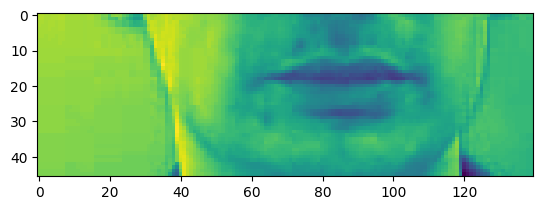

In [16]:
plt.imshow(frames[1])

In [17]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [18]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
# Change - Changed name from "data" to "data_shuffled" so that we can use it later if needed, also added seed
data_shuffled = data.shuffle(500, reshuffle_each_iteration=False, seed=123)
data = data_shuffled.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

In [19]:
train = data.take(450)
test = data.skip(450)

In [20]:
len(data)

500

In [21]:
len([x.decode('utf-8') for x in list(data_shuffled.as_numpy_iterator())][:100])

100

In [22]:
len(test)

50

In [23]:
frames, alignments = data.as_numpy_iterator().next()

In [24]:
len(frames)

2

In [25]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers import legacy

## Model Building

In [26]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [28]:
model.input_shape

(None, 75, 46, 140, 1)

In [29]:
model.output_shape

(None, 75, 41)

In [30]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [31]:
model.compile(optimizer=legacy.Adam(learning_rate=0.0001), loss=CTCLoss)

## Load Best Model

In [32]:
model.load_weights('models/checkpoint')

In [33]:
# Change - Converted test to numpy iterator
test = test.as_numpy_iterator()

In [34]:
test

In [ ]:
# confusion metrics, tts, accuracy, f1 score ----> improvements, create UI

### Major Changes - Evaluation

### Get Predictions

In [35]:
def decode_to_text(inp_arr):
    decoded_arr = []
    
    for ele in inp_arr:
#         tf string is eager tensor
        tf_string = tf.strings.reduce_join([num_to_char(word) for word in ele])
#     Convert eager tensor to numpy first., then you get bytes not a string,then you have to decode the bytes to convert it to a python string
        decoded_arr.append(str(tf_string.numpy().decode('utf-8')))
        
    if len(decoded_arr) == 1:
        return decoded_arr[0]
    return decoded_arr

In [36]:
decode_to_text([[19, 5, 20, 39, 23, 8, 9, 20, 5, 39, 23, 9, 20, 8, 39, 22, 39, 19, 5, 22, 5, 14, 39, 19, 15, 15, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
               ])

'set white with v seven soon'

In [37]:
def get_predictions(data):
    predicted_text_arr = []
    
    pred = model.predict(data)
    for data_slice in pred:
#         np.newaxis adds a new axis to the data slice such that it is comptible with the model imput dimensions
        decoded = tf.keras.backend.ctc_decode(data_slice[np.newaxis,...], input_length=[75], greedy=True)[0][0].numpy()
        text_output = decode_to_text(decoded)
        predicted_text_arr.append(text_output)
    
    return predicted_text_arr

In [38]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [54]:
temp = tf.data.Dataset.list_files(test_path)

In [55]:
temp

<ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [92]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    # File name splitting for windows
#     file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = tf.zeros(5, dtype=tf.int64)
    print(alignments)
    
    return frames, alignments

In [93]:
data = temp.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

In [94]:
test = data.take(1)

In [95]:
next(test.as_numpy_iterator())[0].shape

tf.Tensor([0 0 0 0 0], shape=(5,), dtype=int64)


(1, 75, 46, 140, 1)

In [96]:
pred = get_predictions(next(test.as_numpy_iterator())[0])

tf.Tensor([0 0 0 0 0], shape=(5,), dtype=int64)
1/1 [==============================] - 0s 359ms/step


In [97]:
pred

['se lee it i ixe again']

## Inference Pipeline

In [98]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return (tf.cast(frames, tf.float32) - tf.cast(mean, tf.float32)) / std

In [105]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    # File name splitting for windows
#     file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = tf.zeros(5, dtype=tf.int64)
    
    return frames, alignments

In [99]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [101]:
def decode_to_text(inp_arr):
    decoded_arr = []
    
    for ele in inp_arr:
#         tf string is eager tensor
        tf_string = tf.strings.reduce_join([num_to_char(word) for word in ele])
#     Convert eager tensor to numpy first., then you get bytes not a string,then you have to decode the bytes to convert it to a python string
        decoded_arr.append(str(tf_string.numpy().decode('utf-8')))
        
    if len(decoded_arr) == 1:
        return decoded_arr[0]
    return decoded_arr

In [102]:
def get_predictions(data):
    predicted_text_arr = []
    
    pred = model.predict(data)
    for data_slice in pred:
#         np.newaxis adds a new axis to the data slice such that it is comptible with the model imput dimensions
        decoded = tf.keras.backend.ctc_decode(data_slice[np.newaxis,...], input_length=[75], greedy=True)[0][0].numpy()
        text_output = decode_to_text(decoded)
        predicted_text_arr.append(text_output)
    
    return predicted_text_arr

In [103]:
def inference_pipeline(path):
    data = tf.data.Dataset.list_files(path)
    data = data.map(mappable_function)
    data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
    data = data.prefetch(tf.data.AUTOTUNE)
    
    test = data.take(1)
    pred = get_predictions(next(test.as_numpy_iterator())[0])
    return pred

In [106]:
inference_pipeline("./data/s1/bbaf4p.mpg")

1/1 [==============================] - 0s 377ms/step


['se ree it t hre again']